In [1]:
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline

# let's keep our keras backend tensorflow quiet
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
# for testing on CPU
#os.environ['CUDA_VISIBLE_DEVICES'] = ''

# keras imports for the dataset and building our neural network
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.datasets import mnist
import tensorflow as tf
import pdb
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [2]:
# let's print the shape before we reshape and normalize
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

# building the input vector from the 28x28 pixels
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255

# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)

('X_train shape', (60000, 28, 28))
('y_train shape', (60000,))
('X_test shape', (10000, 28, 28))
('y_test shape', (10000,))
('Train matrix shape', (60000, 784))
('Test matrix shape', (10000, 784))


In [3]:
# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

('Shape before one-hot encoding: ', (60000,))
('Shape after one-hot encoding: ', (60000, 10))


In [4]:
#Assigning the sparsity value to different layers. Sparsity: 1st hidden layer > 2nd hidden layer > output layer

model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))                            
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

model_losses = []
model_accs = []
layerwise_sparsity = []
model_sparsity = []
for sparsity in range(5):
    print('Model training for sparsity # {0}'.format(sparsity+1))
    class LossHistory(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.losses = []
            self.batches = []
            self.weight_save = []
            self.model_weights = model.get_weights()
            self.weight_masks = []
            for i in range(len(self.model_weights)):
                if i%2 == 0:
                    self.random_mask = np.logical_and(np.random.randint(0,2,self.model_weights[i].shape), np.random.randint(0,2,self.model_weights[i].shape))
                    for j in range(sparsity):
                        for layer in range(i):
                            self.random_mask = np.logical_and(self.random_mask, np.random.randint(0,2,self.model_weights[i].shape))
                    self.weight_masks.append(self.random_mask)
            for i in range(len(self.model_weights)):
                if i %2 == 0:
                    self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[i/2])
            model.set_weights(self.model_weights)
            self.weight_save.append(model.get_weights)       

        def on_batch_end(self, batch, logs={}):
            self.losses.append(logs.get('loss'))
            self.batches.append(batch)
            self.model_weights = model.get_weights()
            for i in range(len(self.model_weights)):
                if i %2 == 0:
                    self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[i/2])
            model.set_weights(self.model_weights)
            self.weight_save.append(model.get_weights) 

    l_history=LossHistory()
    history = model.fit(X_train, Y_train,
              batch_size=128, epochs=10, verbose=0,
              validation_data=(X_test, Y_test), callbacks = [es, l_history])

    loss_and_metrics = model.evaluate(X_test, Y_test, verbose=2)
    model_losses.append(loss_and_metrics[0])
    model_accs.append(loss_and_metrics[1])
    for i in range(len(model.get_weights())):
        if i%2==0:
            layerwise_sparsity.append(1 - (np.count_nonzero(model.get_weights()[i])+0.0)/model.get_weights()[i].size)
    model_sparsity.append(layerwise_sparsity)
    layerwise_sparsity = []


Model training for sparsity # 1
Model training for sparsity # 2
Model training for sparsity # 3
Model training for sparsity # 4
Model training for sparsity # 5


In [5]:
print(model_sparsity)
print(model_accs)
print(model_losses)

[[0.7493996133609694, 0.7508010864257812, 0.755078125], [0.7678720902423469, 0.9381103515625, 0.9859375], [0.7703807597257653, 0.9847564697265625, 0.99765625], [0.7766761001275511, 0.9961471557617188, 1.0], [0.8083521006058674, 0.9990768432617188, 1.0]]
[0.9779, 0.9725, 0.5777, 0.1135, 0.1135]
[0.07423141458484461, 0.08674108818410896, 0.9976864389419555, 2.301220866012573, 2.301028649520874]


In [6]:
print(model.summary())
for i in range(len(model.get_weights())):
    print(model.get_weights()[i].shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________
None

Sparsity =1-{non_zero_elements(matrix)}/{matrix.size}


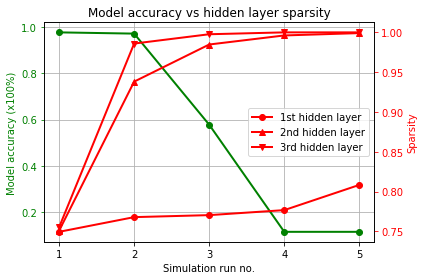

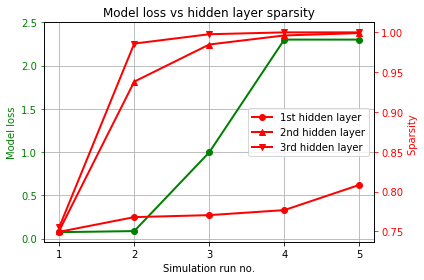

In [7]:
fig, ax1 = plt.subplots()
X_axis = range(1,len(model_accs)+1)

ax1.plot(X_axis,model_accs,'go-', linewidth=2)
ax1.set_xlabel('Simulation run no.')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Model accuracy (x100%)', color='g')
ax1.tick_params('y', colors='g')
ax1.set_xticks(X_axis)
plt.grid(True)

ax2 = ax1.twinx()
ax2.plot(X_axis,[elem[0] for elem in model_sparsity],'ro-', linewidth=2, label = '1st hidden layer' ,marker = "o")
ax2.plot(X_axis,[elem[1] for elem in model_sparsity],'ro-', linewidth=2, label = '2nd hidden layer' ,marker = "^")
ax2.plot(X_axis,[elem[2] for elem in model_sparsity],'ro-', linewidth=2, label = '3rd hidden layer' ,marker = "v")
ax2.set_ylabel('Sparsity', color='r')
ax2.tick_params('y', colors='r')
plt.legend(loc='center right')
plt.title('Model accuracy vs hidden layer sparsity')
fig.tight_layout()

fig, ax1 = plt.subplots()
X_axis = range(1,len(model_losses)+1)

ax1.plot(X_axis,model_losses,'go-', linewidth=2)
ax1.set_xlabel('Simulation run no.')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Model loss', color='g')
ax1.tick_params('y', colors='g')
ax1.set_xticks(X_axis)
ax1.set_yticks([0, 0.5, 1.0, 1.5, 2.0, 2.5])
plt.grid(True)

ax2 = ax1.twinx()
ax2.plot(X_axis,[elem[0] for elem in model_sparsity],'ro-', linewidth=2, label = '1st hidden layer' ,marker = "o")
ax2.plot(X_axis,[elem[1] for elem in model_sparsity],'ro-', linewidth=2, label = '2nd hidden layer' ,marker = "^")
ax2.plot(X_axis,[elem[2] for elem in model_sparsity],'ro-', linewidth=2, label = '3rd hidden layer' ,marker = "v")
ax2.set_ylabel('Sparsity ', color='r')
ax2.tick_params('y', colors='r')
plt.legend()
plt.title('Model loss vs hidden layer sparsity')
fig.tight_layout()
print('Sparsity =1-{non_zero_elements(matrix)}/{matrix.size}')